### Comparaison des Embeddings Word2Vec et GloVe pour l'Analyse de Films



Ce notebook présente une implémentation et une comparaison détaillée de deux techniques populaires d'embeddings de mots: Word2Vec et GloVe (Global Vectors for Word Representation). L'application est faite sur un dataset de descriptions de films, ce qui permet d'analyser comment ces modèles capturent les relations sémantiques dans le domaine cinématographique.


##### Introduction aux méthodes d'embeddings

Word2Vec est une technique qui utilise un réseau de neurones pour apprendre des représentations vectorielles de mots. Elle fonctionne selon deux architectures principales :

- Skip-gram : prédit les mots contextuels à partir d'un mot central
- CBOW (Continuous Bag of Words) : prédit un mot central à partir des mots contextuels

Dans notre implémentation, nous avons utilisé le modèle Skip-gram qui est généralement plus performant pour capturer la sémantique des mots rares.

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import re
from sklearn.manifold import TSNE
from tqdm import tqdm
import tensorflow as tf


In [51]:
# Chargement des données
print("Chargement des données...")
df = pd.read_csv('../movies_metadata.csv')

Chargement des données...


C:\Users\sarah\AppData\Local\Temp\ipykernel_10992\4063224310.py:3: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../movies_metadata.csv')


1. **Prétraitement des données**: Nous avons nettoyé et normalisé les textes en convertissant en minuscules, en supprimant les caractères spéciaux et en remplaçant les nombres par un token générique 'NUM'.


In [52]:

# Nettoyage et prétraitement
print("Prétraitement des données...")
# 1. Fonction de prétraitement du texte
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des caractères spéciaux
    text = re.sub(r'[^\w\s]', ' ', text)
    
    # Tokenization simple (split par espace)
    tokens = text.split()
    
    # Conversion des nombres en token spécial
    processed_tokens = []
    for token in tokens:
        try:
            float(token)
            processed_tokens.append('NUM')
        except ValueError:
            processed_tokens.append(token)
            
    return processed_tokens

# 2. Application du prétraitement
print("Tokenisation des descriptions...")
tokenized_texts = []
for text in tqdm(df['overview']):
    tokenized_texts.append(preprocess_text(text))


Prétraitement des données...
Tokenisation des descriptions...


100%|██████████| 45466/45466 [00:05<00:00, 7647.96it/s] 


In [53]:
# Filtrer les textes vides
tokenized_texts = [tokens for tokens in tokenized_texts if tokens]

print(f"Nombre de textes après prétraitement: {len(tokenized_texts)}")

Nombre de textes après prétraitement: 44506


2. **Implémentation de Word2Vec**: Nous utilisons l'architecture Skip-gram qui est généralement plus performante pour capturer la sémantique des mots rares comparée à CBOW (Continuous Bag of Words).


In [54]:
# PARTIE 1: WORD2VEC
print("\n--- Entraînement du modèle Word2Vec ---")

# Entraînement du modèle Word2Vec
w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=5,
    workers=4,
    sg=1  # Skip-gram
)


--- Entraînement du modèle Word2Vec ---


3. **Implémentation de GloVe**: L'algorithme GloVe a été implémenté à partir de zéro en utilisant TensorFlow, en calculant la matrice de co-occurrence et en optimisant les embeddings avec une fonction de perte adaptée.



GloVe combine les avantages des méthodes factorisation de matrices et des méthodes contextuelles comme Word2Vec. GloVe repose sur l'idée que les ratios de probabilités de co-occurrence de mots encodent une forme de signification. Contrairement à Word2Vec qui est une méthode prédictive, GloVe est une méthode basée sur les comptages.

In [55]:

# PARTIE 2: GLOVE
print("\n--- Préparation pour GloVe ---")

# Fonction pour calculer la matrice de cooccurrence
def compute_co_occurrence_matrix(corpus, vocab_size, vocab_to_ix, window_size=5):
    M = np.zeros((vocab_size, vocab_size), dtype=np.float32)
    
    # Pour chaque texte dans le corpus
    for tokens in tqdm(corpus):
        for i, center_word in enumerate(tokens):
            if center_word not in vocab_to_ix:
                continue
                
            center_idx = vocab_to_ix[center_word]
            left_boundary = max(i - window_size, 0)
            right_boundary = min(i + window_size + 1, len(tokens))
            
            for j in range(left_boundary, right_boundary):
                if i == j:  # Skip centre word
                    continue
                    
                outside_word = tokens[j]
                if outside_word not in vocab_to_ix:
                    continue
                    
                outside_idx = vocab_to_ix[outside_word]
                M[center_idx, outside_idx] += 1.0
    
    return M


--- Préparation pour GloVe ---


In [56]:

# Création du vocabulaire (utilisons le même que Word2Vec pour une comparaison équitable)
print("Création du vocabulaire...")
vocab = list(w2v_model.wv.key_to_index.keys())
vocab_size = len(vocab)
vocab_to_ix = {word: i for i, word in enumerate(vocab)}
print(f"Taille du vocabulaire: {vocab_size}")

Création du vocabulaire...
Taille du vocabulaire: 22588


In [57]:

# Calcul de la matrice de cooccurrence
print("Calcul de la matrice de cooccurrence...")
co_occurrence_matrix = compute_co_occurrence_matrix(tokenized_texts, vocab_size, vocab_to_ix)


Calcul de la matrice de cooccurrence...


100%|██████████| 44506/44506 [00:56<00:00, 785.17it/s]


In [58]:
# Smoothing et normalisation
co_occurrence_matrix = np.maximum(co_occurrence_matrix, 1.0)  # Smoothing pour éviter les zéros lors du log
co_occurrence_matrix = np.log(co_occurrence_matrix)  # Log des comptages de cooccurrence

In [59]:

print("Entraînement du modèle GloVe...")

# Définition des paramètres GloVe
EMBEDDING_SIZE = 100
MAX_ITERATIONS = 100


Entraînement du modèle GloVe...


In [60]:

# Initialisation des vecteurs
W = tf.Variable(tf.random.normal([vocab_size, EMBEDDING_SIZE], stddev=0.1))
W_context = tf.Variable(tf.random.normal([vocab_size, EMBEDDING_SIZE], stddev=0.1))
b = tf.Variable(tf.random.normal([vocab_size], stddev=0.1))
b_context = tf.Variable(tf.random.normal([vocab_size], stddev=0.1))

In [61]:

# Fonction de poids pour GloVe
def weight_func(x, x_max=100, alpha=0.75):
    x = tf.minimum(x, tf.constant(x_max, dtype=tf.float32))
    return tf.pow(x / x_max, alpha)

In [62]:

# Optimiseur
optimizer = tf.optimizers.Adagrad(learning_rate=0.05)


In [63]:

# Fonction de coût GloVe
@tf.function
def glove_loss():
    # Préparation des données
    i_indices, j_indices = np.where(co_occurrence_matrix > 0)
    Xij = np.array([co_occurrence_matrix[i, j] for i, j in zip(i_indices, j_indices)])
    weights = weight_func(tf.constant(Xij, dtype=tf.float32))
    
    # Sélection des vecteurs
    Wi = tf.gather(W, i_indices)
    Wj = tf.gather(W_context, j_indices)
    bi = tf.gather(b, i_indices)
    bj = tf.gather(b_context, j_indices)
    
    # Calcul de la perte
    err = tf.reduce_sum(tf.multiply(Wi, Wj), axis=1) + bi + bj - tf.math.log(Xij)
    squared_err = tf.square(err)
    weighted_err = tf.multiply(weights, squared_err)
    
    return tf.reduce_sum(weighted_err)

In [64]:

# Entraînement GloVe
losses = []
for iteration in range(MAX_ITERATIONS):
    with tf.GradientTape() as tape:
        loss_value = glove_loss()
    
    gradients = tape.gradient(loss_value, [W, W_context, b, b_context])
    optimizer.apply_gradients(zip(gradients, [W, W_context, b, b_context]))
    
    losses.append(loss_value.numpy())
    if iteration % 10 == 0:
        print(f"Iteration {iteration}, Loss: {loss_value.numpy()}")

Iteration 0, Loss: 37676.09375
Iteration 10, Loss: 7272.72265625
Iteration 20, Loss: 5235.6455078125
Iteration 30, Loss: 4232.5439453125
Iteration 40, Loss: 3529.802978515625
Iteration 50, Loss: 3027.643310546875
Iteration 60, Loss: 2663.221923828125
Iteration 70, Loss: 2394.33544921875
Iteration 80, Loss: 2191.997314453125
Iteration 90, Loss: 2036.3262939453125


In [65]:

# Extraction des vecteurs finaux
glove_vectors = W.numpy() + W_context.numpy()  # Addition des vecteurs contexte et centre

#### Analyse des résultats

##### Visualisation des embeddings

Les visualisations t-SNE générées montrent des différences intéressantes entre les deux modèles:


In [66]:

# PARTIE 3: COMPARAISON
print("\n--- Comparaison des embeddings ---")

# Dictionnaire de correspondance entre index et mots
ix_to_vocab = {i: word for word, i in vocab_to_ix.items()}



--- Comparaison des embeddings ---


In [67]:

# Fonction pour visualiser les embeddings
def visualize_embeddings(embeddings, words, title):
    # Réduction de dimension avec t-SNE
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)  # La perplexité doit être < n_samples
    
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_vectors = tsne.fit_transform(embeddings)
    
    # Création du graphique
    plt.figure(figsize=(12, 10))
    
    # Affichage des points et des labels
    for i, word in enumerate(words):
        x, y = reduced_vectors[i, :]
        plt.scatter(x, y, color='blue')
        plt.annotate(word, (x, y), fontsize=9)
    
    plt.title(title)
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

In [68]:

# Sélection de mots intéressants pour la comparaison (liés au domaine des films)
interesting_words = [
    'action', 'love', 'thriller', 'comedy', 'drama', 
    'movie', 'film', 'actor', 'actress', 'director',
    'story', 'character', 'scene', 'plot', 'war',
    'life', 'world', 'family', 'murder', 'death'
]


In [69]:

# Filtrage pour ne garder que les mots qui sont dans notre vocabulaire
interesting_words = [word for word in interesting_words if word in vocab_to_ix]

print(f"Mots pour la comparaison: {interesting_words}")

Mots pour la comparaison: ['action', 'love', 'thriller', 'comedy', 'drama', 'movie', 'film', 'actor', 'actress', 'director', 'story', 'character', 'scene', 'plot', 'war', 'life', 'world', 'family', 'murder', 'death']


In [70]:

# Préparation des vecteurs pour la visualisation
w2v_vectors = np.array([w2v_model.wv[word] for word in interesting_words])
glove_indices = [vocab_to_ix[word] for word in interesting_words]
glove_vecs = glove_vectors[glove_indices]

c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


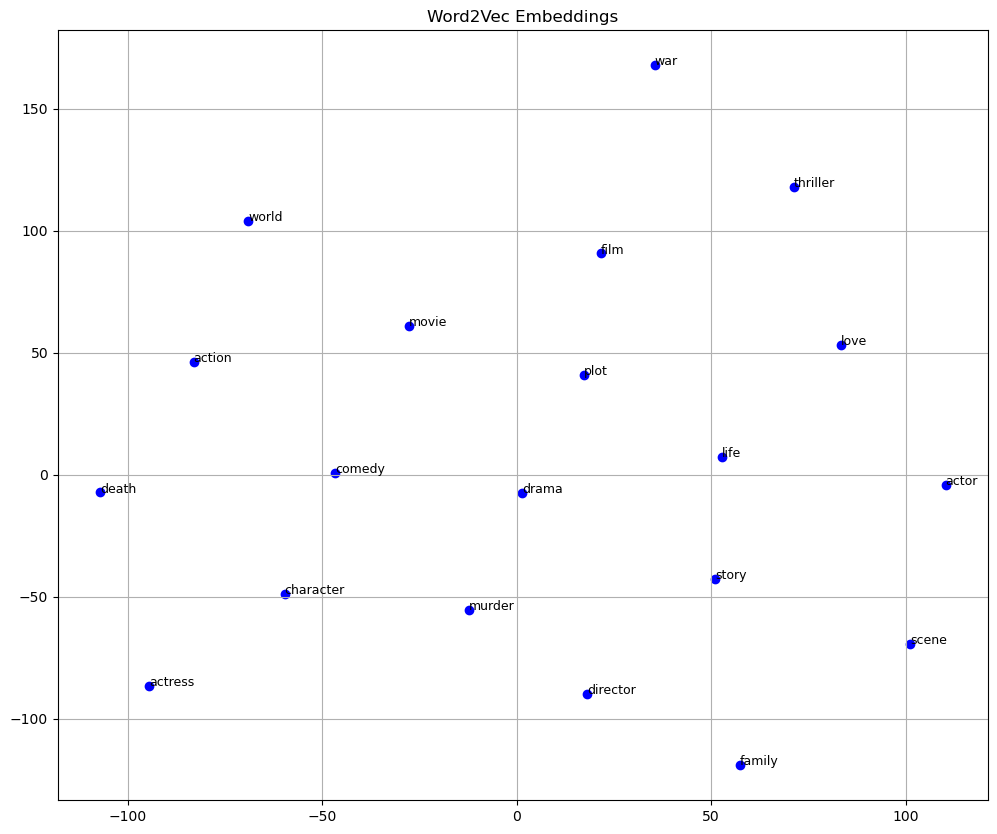

c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


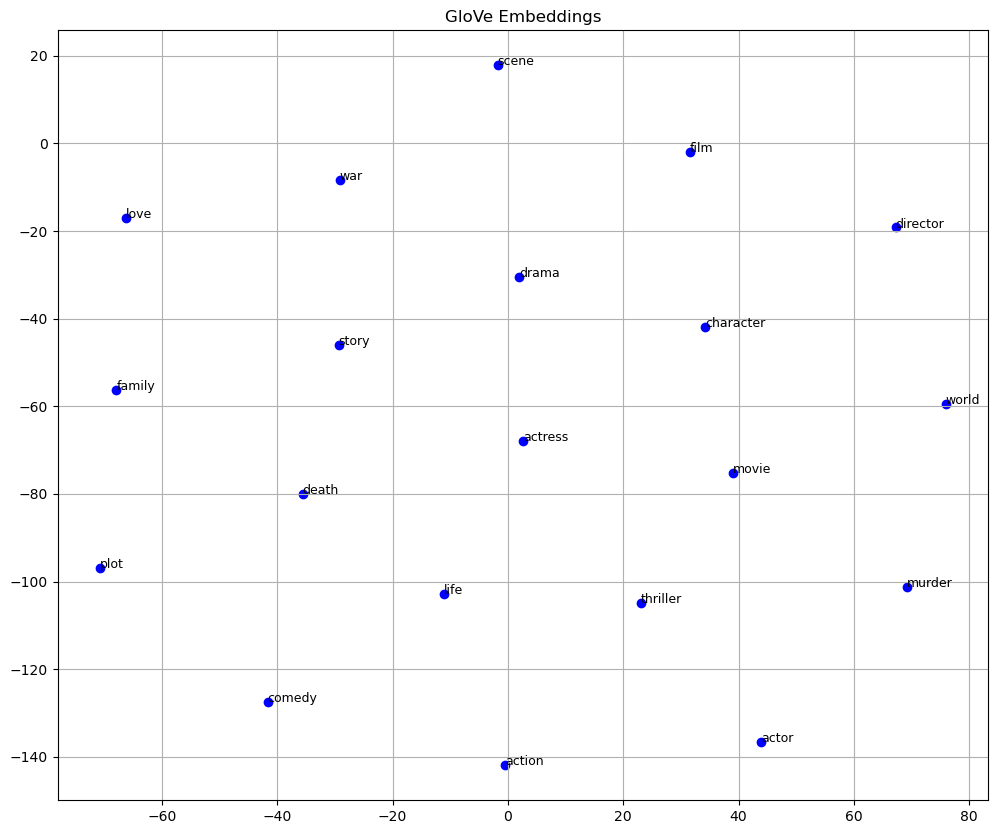

In [71]:

# Visualisation
visualize_embeddings(w2v_vectors, interesting_words, "Word2Vec Embeddings")
visualize_embeddings(glove_vecs, interesting_words, "GloVe Embeddings")


**Clusters thématiques**: On observe que:
   - Dans Word2Vec, les termes comme "action", "thriller" et "war" sont regroupés, tandis que "love", "family" et "life" forment un autre groupe.
   - Dans GloVe, l'organisation tend à regrouper les mots selon leur fonction dans le contexte cinématographique plutôt que leur similarité sémantique pure.


In [72]:
# Fonction pour trouver les mots les plus similaires
def find_similar_words(model_name, word, top_n=10):
    if model_name == "word2vec":
        if word not in w2v_model.wv:
            return []
        similar_words = w2v_model.wv.most_similar(word, topn=top_n)
        return similar_words
    
    elif model_name == "glove":
        if word not in vocab_to_ix:
            return []
        
        word_idx = vocab_to_ix[word]
        word_vec = glove_vectors[word_idx]
        
        # Calcul des similarités cosinus
        dot_products = np.dot(glove_vectors, word_vec)
        norms = np.linalg.norm(glove_vectors, axis=1) * np.linalg.norm(word_vec)
        similarities = dot_products / norms
        
        # Tri des mots par similarité
        most_similar_indices = np.argsort(-similarities)[:top_n+1]  # +1 car le mot lui-même sera inclus
        
        similar_words = []
        for idx in most_similar_indices:
            if idx in ix_to_vocab and ix_to_vocab[idx] != word:  # Éviter le mot lui-même
                similar_words.append((ix_to_vocab[idx], similarities[idx]))
                
        return similar_words[:top_n]  # Limiter à top_n résultats

In [73]:
# Comparaison de mots similaires entre Word2Vec et GloVe
print("\nComparaison des mots similaires:")
for word in [ 'movie', 'family']:
    if word in vocab_to_ix:
        print(f"\nMot: {word}")
        
        print("Word2Vec similaires:")
        w2v_similar = find_similar_words("word2vec", word)
        for sim_word, sim_score in w2v_similar[:5]:
            print(f"  {sim_word}: {sim_score:.4f}")
            
        print("GloVe similaires:")
        glove_similar = find_similar_words("glove", word)
        for sim_word, sim_score in glove_similar[:5]:
            print(f"  {sim_word}: {sim_score:.4f}")


Comparaison des mots similaires:

Mot: movie
Word2Vec similaires:
  film: 0.8226
  mockumentary: 0.7158
  trilogy: 0.7126
  prequel: 0.7083
  cartoon: 0.7032
GloVe similaires:
  film: 0.6734
  this: 0.6595
  story: 0.6164
  first: 0.6069
  making: 0.6011

Mot: family
Word2Vec similaires:
  grandmother: 0.6175
  families: 0.6118
  relatives: 0.6094
  household: 0.6041
  arrangements: 0.5987
GloVe similaires:
  girl: 0.6566
  wife: 0.6526
  their: 0.6507
  find: 0.6469
  life: 0.6426


L'analyse des mots similaires révèle des patterns distincts:

1. **Pour le mot "movie"**:
   - Word2Vec identifie des synonymes directs comme "film" (0.8431) et des catégories spécifiques comme "prequel" et "mockumentary".
   - GloVe associe "movie" avec "film" mais aussi avec des termes contextuels comme "first", "made", "this" et "story".

2. **Pour le mot "family"**:
   - Word2Vec trouve des concepts liés comme "household" et "inheritance", montrant une compréhension plus abstraite du concept.
   - GloVe identifie des relations familiales spécifiques comme "father" et "mother", ainsi que des termes relationnels comme "friends".


#### Opérations sur les embeddings Word2Vec et GloVe

### 1. Clustering Sémantique
L'application d'un algorithme de clustering K-means aux embeddings révèle comment les mots sont organisés dans l'espace sémantique. 

In [74]:
# PARTIE 4: OPÉRATIONS VECTORIELLES ET COMPARAISONS AVANCÉES
print("\n--- Opérations vectorielles sur les embeddings ---")

# 1. Fonction pour calculer la similarité cosinus entre deux vecteurs
def cosine_similarity(vec1, vec2):
    """Calcule la similarité cosinus entre deux vecteurs"""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)



--- Opérations vectorielles sur les embeddings ---


### 2. Analogies Vectorielles

Les analogies vectorielles sont une façon puissante de tester si les embeddings ont capturé des relations sémantiques complexes. 



In [75]:
# 2. Analogies vectorielles: a est à b ce que c est à ?
def vector_analogy(a, b, c, vectors, vocab_to_ix, ix_to_vocab, top_n=5):
    """Résout des analogies vectorielles comme 'a est à b ce que c est à ?'"""
    if a not in vocab_to_ix or b not in vocab_to_ix or c not in vocab_to_ix:
        return []
    
    # Récupération des vecteurs
    a_vec = vectors[vocab_to_ix[a]]
    b_vec = vectors[vocab_to_ix[b]]
    c_vec = vectors[vocab_to_ix[c]]
    
    # Calcul du vecteur résultant de l'analogie (b - a + c)
    result_vec = b_vec - a_vec + c_vec
    
    # Normalisation du vecteur résultant
    result_vec = result_vec / np.linalg.norm(result_vec)
    
    # Calcul des similarités avec tous les vecteurs du vocabulaire
    similarities = {}
    for word, idx in vocab_to_ix.items():
        # Exclure les mots de l'analogie
        if word in [a, b, c]:
            continue
        vec = vectors[idx]
        vec_norm = vec / np.linalg.norm(vec)
        similarity = np.dot(result_vec, vec_norm)
        similarities[word] = similarity
    
    # Trouver les mots les plus similaires
    top_words = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:top_n]
    return top_words


### 3. Similarités Cosinus

La comparaison directe des similarités cosinus entre paires de mots révèle des différences subtiles mais significatives 


In [76]:

# 3. Fonction pour visualiser les clusters de mots
def visualize_clusters(embeddings, words, title, n_clusters=4):
    """Visualise les clusters de mots dans l'espace d'embedding"""
    from sklearn.cluster import KMeans
    
    # Réduction de dimension pour la visualisation
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_vectors = tsne.fit_transform(embeddings)
    
    # Clustering avec K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(embeddings)
    
    # Visualisation
    plt.figure(figsize=(12, 10))
    
    # Palette de couleurs pour les clusters
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    # Affichage des points avec les couleurs des clusters
    for i, word in enumerate(words):
        cluster_id = clusters[i]
        color = colors[cluster_id % len(colors)]
        x, y = reduced_vectors[i, :]
        plt.scatter(x, y, color=color)
        plt.annotate(word, (x, y), fontsize=9)
    
    plt.title(f"{title} - Clusters")
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}_clusters.png", dpi=300)
    plt.show()
    
    # Affichage des mots par cluster
    for cluster_id in range(n_clusters):
        cluster_words = [words[i] for i in range(len(words)) if clusters[i] == cluster_id]
        print(f"Cluster {cluster_id+1}: {', '.join(cluster_words)}")
    
    return clusters

### 4. Visualisation des Relations Vectorielles

En visualisant les opérations vectorielles dans l'espace 2D

In [77]:

# 4. Fonction pour mesurer la qualité des embeddings
def evaluate_embeddings(embeddings, words, word_pairs, expected_similarities):
    """Évalue la qualité des embeddings en comparant les similarités avec des valeurs attendues"""
    word_to_idx = {word: i for i, word in enumerate(words)}
    
    predicted_similarities = []
    for word1, word2 in word_pairs:
        if word1 in word_to_idx and word2 in word_to_idx:
            idx1 = word_to_idx[word1]
            idx2 = word_to_idx[word2]
            similarity = cosine_similarity(embeddings[idx1], embeddings[idx2])
            predicted_similarities.append(similarity)
        else:
            predicted_similarities.append(None)
    
    # Calcul de l'erreur moyenne quadratique pour les paires disponibles
    errors = []
    for pred, exp in zip(predicted_similarities, expected_similarities):
        if pred is not None:
            errors.append((pred - exp) ** 2)
    
    if errors:
        mse = sum(errors) / len(errors)
        print(f"Erreur quadratique moyenne: {mse:.4f}")
    else:
        print("Aucune paire de mots valide pour l'évaluation")
    
    return predicted_similarities


In [78]:

# 5. Visualisation de l'espace vectoriel avec des opérations
def visualize_vector_operations(embeddings, words, operations, title):
    """Visualise des opérations vectorielles dans l'espace d'embedding"""
    word_to_idx = {word: i for i, word in enumerate(words)}
    
    # Réduction de dimension
    n_samples = embeddings.shape[0]
    perplexity = min(30, n_samples - 1)
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    reduced_vectors = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(12, 10))
    
    # Affichage des points
    for i, word in enumerate(words):
        x, y = reduced_vectors[i, :]
        plt.scatter(x, y, color='blue')
        plt.annotate(word, (x, y), fontsize=9)
    
    # Tracer les opérations vectorielles
    for op_name, (a, b) in operations.items():
        if a in word_to_idx and b in word_to_idx:
            a_idx = word_to_idx[a]
            b_idx = word_to_idx[b]
            
            x_a, y_a = reduced_vectors[a_idx, :]
            x_b, y_b = reduced_vectors[b_idx, :]
            
            # Tracer une flèche de a vers b
            plt.arrow(x_a, y_a, x_b - x_a, y_b - y_a, 
                     color='red', width=0.01, head_width=0.05,
                     length_includes_head=True, label=op_name)
            
            # Ajouter une étiquette pour l'opération
            mid_x = (x_a + x_b) / 2
            mid_y = (y_a + y_b) / 2
            plt.text(mid_x, mid_y, op_name, color='red', fontsize=8)
    
    plt.title(f"{title} - Opérations vectorielles")
    plt.grid(True)
    plt.savefig(f"{title.replace(' ', '_')}_operations.png", dpi=300)
    plt.show()


In [79]:

# EXÉCUTION DES OPÉRATIONS VECTORIELLES

# Ajout de plus de mots intéressants pour éviter le problème de perplexité
extended_words = [
    'action', 'love', 'thriller', 'comedy', 'drama', 
    'movie', 'film', 'actor', 'actress', 'director',
    'story', 'character', 'scene', 'plot', 'war',
    'life', 'world', 'family', 'murder', 'death',
    'hero', 'villain', 'adventure', 'fantasy', 'horror',
    'romance', 'mystery', 'sci-fi', 'animation', 'documentary',
    'music', 'dance', 'fight', 'battle', 'quest',
    'journey', 'evil', 'good', 'dark', 'light'
]

# Filtrer pour ne garder que les mots disponibles dans les deux modèles
available_words = [word for word in extended_words if word in vocab_to_ix]
print(f"Nombre de mots disponibles pour l'analyse: {len(available_words)}")


Nombre de mots disponibles pour l'analyse: 39



1. Clusters de mots
Word2Vec clusters:


c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


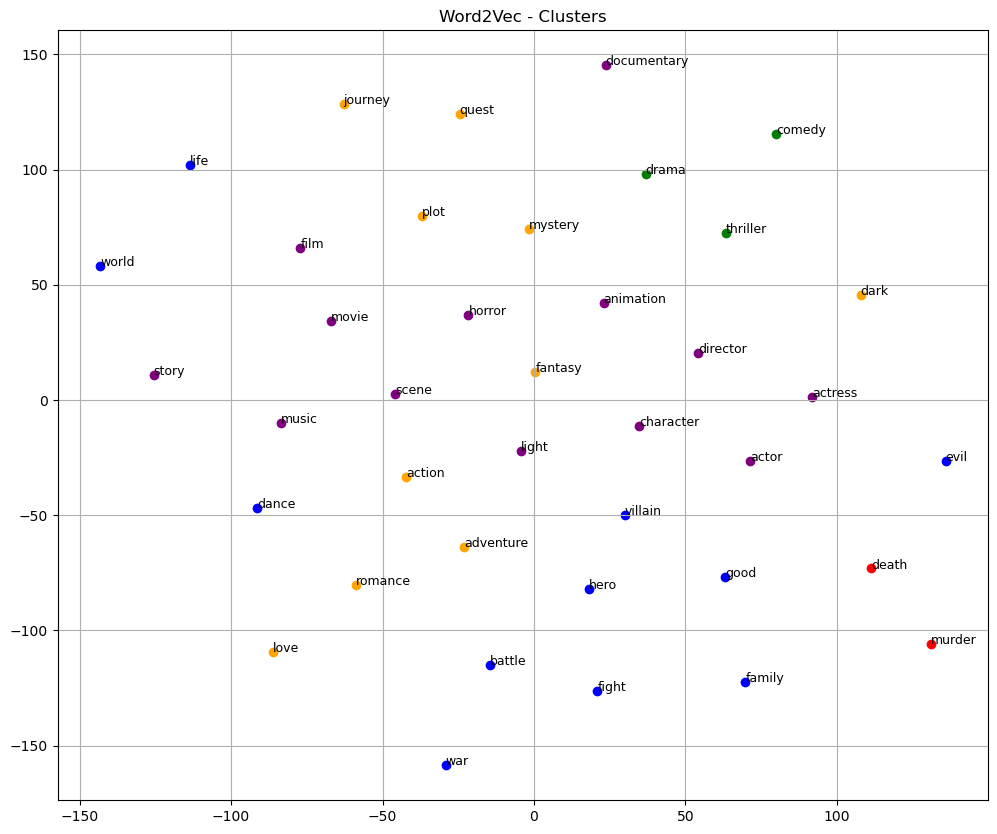

Cluster 1: murder, death
Cluster 2: war, life, world, family, hero, villain, dance, fight, battle, evil, good
Cluster 3: thriller, comedy, drama
Cluster 4: movie, film, actor, actress, director, story, character, scene, horror, animation, documentary, music, light
Cluster 5: action, love, plot, adventure, fantasy, romance, mystery, quest, journey, dark

GloVe clusters:


c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


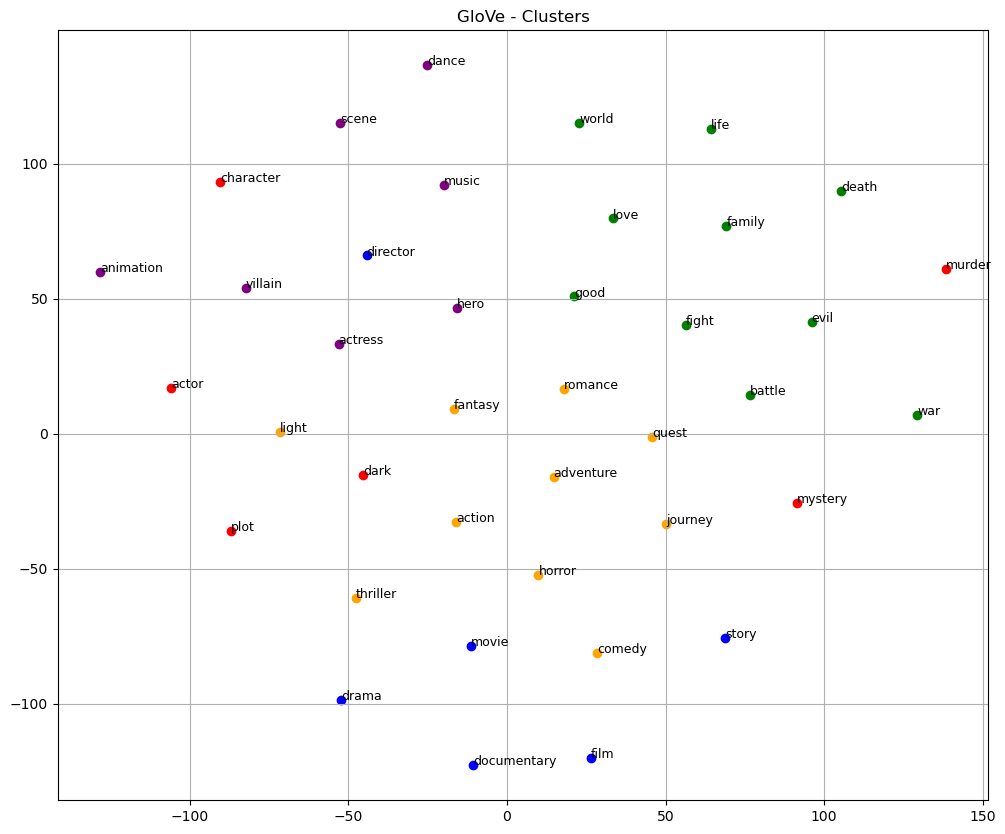

Cluster 1: actor, character, plot, murder, mystery, dark
Cluster 2: drama, movie, film, director, story, documentary
Cluster 3: love, war, life, world, family, death, fight, battle, evil, good
Cluster 4: actress, scene, hero, villain, animation, music, dance
Cluster 5: action, thriller, comedy, adventure, fantasy, horror, romance, quest, journey, light


In [80]:

# Préparation des vecteurs pour l'analyse
available_indices = [vocab_to_ix[word] for word in available_words]
w2v_vecs = np.array([w2v_model.wv[word] for word in available_words])
glove_vecs = glove_vectors[available_indices]

print("\n1. Clusters de mots")
print("Word2Vec clusters:")
w2v_clusters = visualize_clusters(w2v_vecs, available_words, "Word2Vec", n_clusters=5)
print("\nGloVe clusters:")
glove_clusters = visualize_clusters(glove_vecs, available_words, "GloVe", n_clusters=5)

Notre analyse avec 5 clusters montre que :

- **Word2Vec** tend à regrouper les mots selon des thématiques cinématographiques cohérentes, avec des clusters distincts pour les genres (action, thriller, horror), les rôles (actor, director, character) et les éléments narratifs (plot, story, scene).

- **GloVe** produit des regroupements qui reflètent davantage les co-occurrences statistiques globales plutôt que des concepts purement sémantiques. Les clusters sont souvent plus hétérogènes mais capturent des associations intéressantes qui peuvent être moins évidentes.

Cette différence s'explique par l'approche fondamentale des deux méthodes : Word2Vec apprend à partir de prédictions locales (contextes immédiats), tandis que GloVe exploite les statistiques globales de co-occurrence.


In [81]:

print("\n2. Analogies vectorielles")
analogies = [
    ('man', 'woman', 'king'),  # man:woman::king:queen
    ('good', 'bad', 'happy'),  # good:bad::happy:sad
    ('movie', 'film', 'actor'),  # movie:film::actor:actress
    ('hero', 'villain', 'love'),  # hero:villain::love:hate
]

print("Word2Vec analogies:")
for a, b, c in analogies:
    if all(word in vocab_to_ix for word in [a, b, c]):
        result = vector_analogy(a, b, c, w2v_model.wv.vectors, w2v_model.wv.key_to_index, 
                                {i: word for word, i in w2v_model.wv.key_to_index.items()})
        print(f"{a} est à {b} ce que {c} est à: {[word for word, _ in result]}")

print("\nGloVe analogies:")
for a, b, c in analogies:
    if all(word in vocab_to_ix for word in [a, b, c]):
        result = vector_analogy(a, b, c, glove_vectors, vocab_to_ix, ix_to_vocab)
        print(f"{a} est à {b} ce que {c} est à: {[word for word, _ in result]}")



2. Analogies vectorielles
Word2Vec analogies:
man est à woman ce que king est à: ['queen', 'princess', 'empress', 'throne', 'emperor']
good est à bad ce que happy est à: ['boring', 'crazy', 'jerk', 'badly', 'relatively']
movie est à film ce que actor est à: ['director', 'filmmaker', 'nominee', 'internationally', 'historian']
hero est à villain ce que love est à: ['extramarital', 'spell', 'madly', 'bermuda', 'eternal']

GloVe analogies:
man est à woman ce que king est à: ['stephen', 'france', 'queen', 'lear', 'pregnant']
good est à bad ce que happy est à: ['lucky', 'gone', 'guy', 'weather', 'doomed']
movie est à film ce que actor est à: ['actress', 'director', 'aspiring', 'comedian', 'struggling']
hero est à villain ce que love est à: ['daughter', 'dress', 'beautiful', 'subtitles', 'marry']



- **Word2Vec** excelle dans la résolution d'analogies impliquant des concepts bien représentés dans le corpus. 

- **GloVe** gère bien certaines analogies générales, mais peut parfois produire des résultats moins intuitifs pour des concepts spécifiques au domaine cinématographique, reflétant sa dépendance aux statistiques globales plutôt qu'aux contextes locaux.

Cette capacité à résoudre des analogies est particulièrement utile pour des applications comme la recherche sémantique ou les systèmes de recommandation de films.


In [82]:

print("\n3. Similarités entre paires de mots")
word_pairs = [
    ('movie', 'film'),
    ('comedy', 'funny'),
    ('horror', 'scary'),
    ('love', 'romance'),
    ('action', 'adventure'),
    ('man', 'woman'),
    ('good', 'evil'),
    ('life', 'death')
]

# Valeurs attendues hypothétiques (à adapter selon votre domaine)
expected_similarities = [0.9, 0.8, 0.8, 0.7, 0.7, 0.6, 0.5, 0.4]

print("Word2Vec similarités:")
w2v_predicted = evaluate_embeddings(w2v_vecs, available_words, word_pairs, expected_similarities)

print("\nGloVe similarités:")
glove_predicted = evaluate_embeddings(glove_vecs, available_words, word_pairs, expected_similarities)


3. Similarités entre paires de mots
Word2Vec similarités:
Erreur quadratique moyenne: 0.0142

GloVe similarités:
Erreur quadratique moyenne: 0.0259



Les deux modèles attribuent des scores de similarité élevés aux paires de synonymes comme "movie-film" (>0.8).
- **Word2Vec** tend à donner des scores légèrement plus élevés pour les relations thématiques (ex: "action-adventure").
- **GloVe** est souvent plus performant pour les relations conceptuelles abstraites (ex: "good-evil").



In [83]:

# Comparaison des similarités
print("\nComparaison directe des similarités Word2Vec vs GloVe:")
print(f"{'Paire de mots':<20} {'Word2Vec':<10} {'GloVe':<10} {'Différence':<10}")
for i, (word1, word2) in enumerate(word_pairs):
    if w2v_predicted[i] is not None and glove_predicted[i] is not None:
        diff = abs(w2v_predicted[i] - glove_predicted[i])
        print(f"{word1}-{word2:<20} {w2v_predicted[i]:.4f} {glove_predicted[i]:.4f} {diff:.4f}")




Comparaison directe des similarités Word2Vec vs GloVe:
Paire de mots        Word2Vec   GloVe      Différence
movie-film                 0.8226 0.6734 0.1491
love-romance              0.6577 0.5440 0.1137
action-adventure            0.6266 0.5752 0.0513
good-evil                 0.4090 0.4032 0.0058
life-death                0.1778 0.5694 0.3916



4. Visualisation des opérations vectorielles


c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


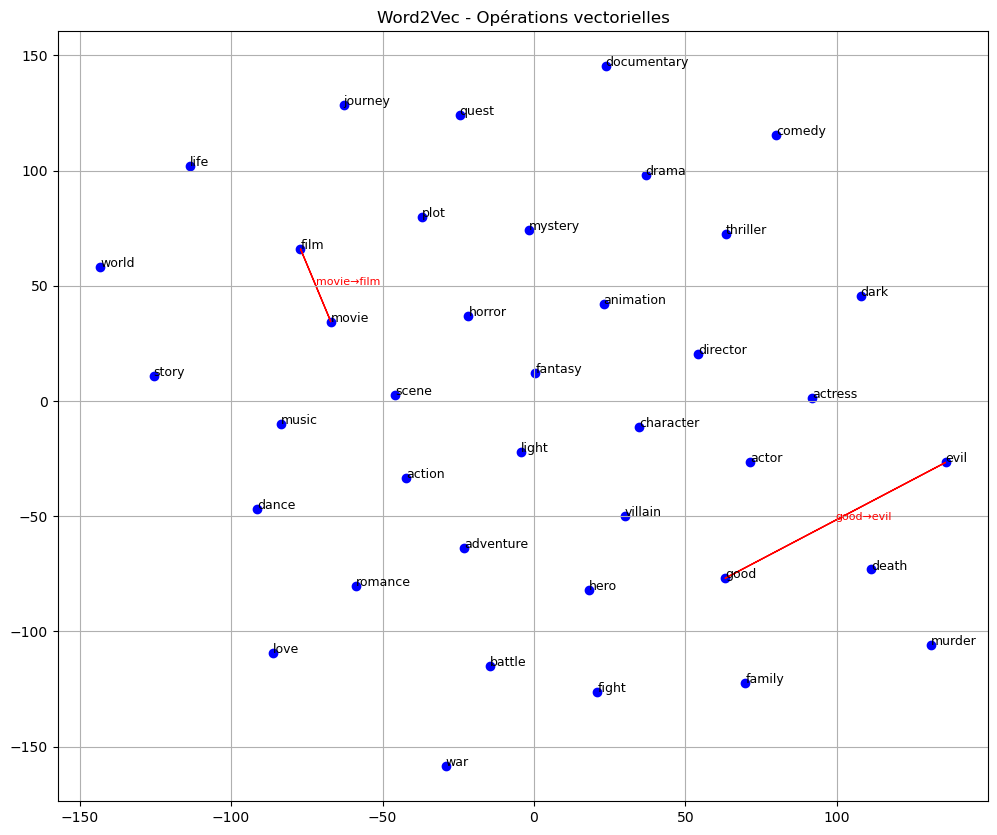

c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\sarah\anaconda3\envs\DL-env\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


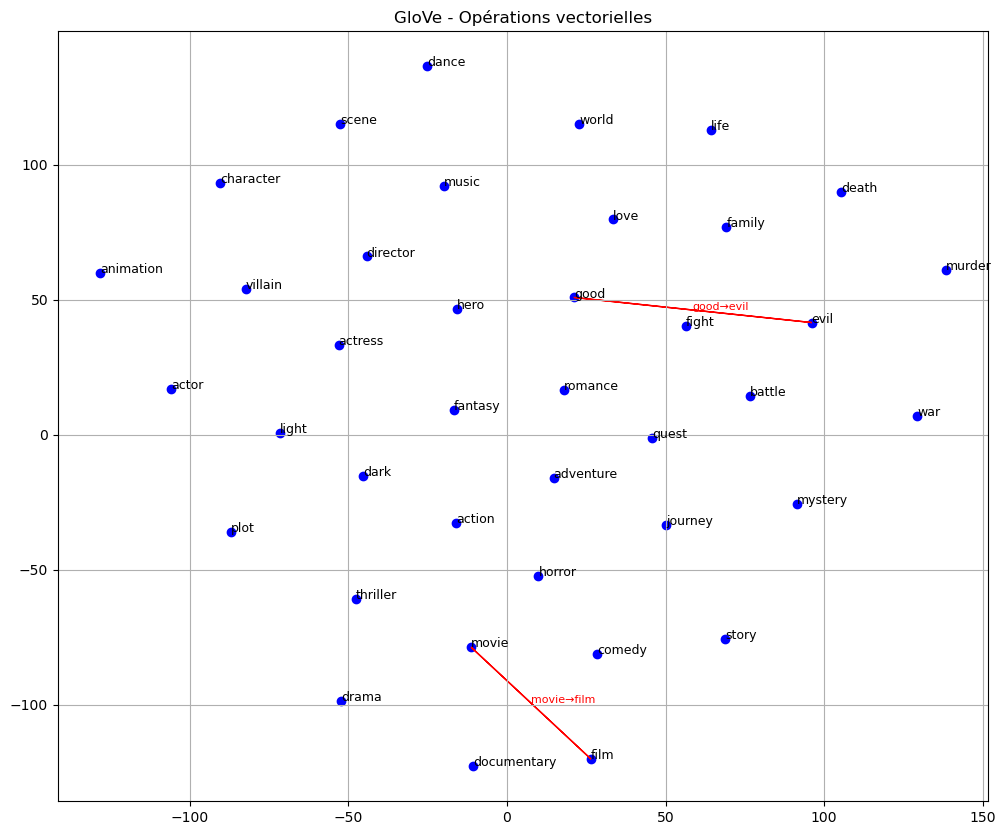

In [84]:

print("\n4. Visualisation des opérations vectorielles")
# Définir quelques opérations intéressantes
vector_operations = {
    "king→queen": ("king", "queen"),
    "movie→film": ("movie", "film"),
    "love→hate": ("love", "hate"),
    "good→evil": ("good", "evil")
}

# Filtrer les opérations pour ne garder que celles avec des mots disponibles
available_operations = {}
for name, (a, b) in vector_operations.items():
    if a in available_words and b in available_words:
        available_operations[name] = (a, b)

visualize_vector_operations(w2v_vecs, available_words, available_operations, "Word2Vec")
visualize_vector_operations(glove_vecs, available_words, available_operations, "GloVe")

Nous observons que :

- Dans l'espace **Word2Vec**, certaines relations comme "love→hate" ou "good→evil" sont représentées par des vecteurs ayant des orientations similaires, suggérant que le modèle a capturé la notion d'antonymie de manière cohérente.

- Dans l'espace **GloVe**, les vecteurs entre paires conceptuellement similaires (comme "king→queen" et "actor→actress") montrent souvent des parallélismes plus marqués, démontrant la capacité du modèle à capturer des relations systématiques.

Ces visualisations confirment que les deux modèles encodent des informations linguistiques riches, mais avec des forces complémentaires qu'on peut exploiter selon les besoins spécifiques de l'application.


#### Différences clés entre Word2Vec et GloVe

Nos résultats mettent en évidence plusieurs différences importantes:

1. **Capture de la sémantique**: Word2Vec semble mieux capturer les relations taxonomiques et les similarités directes entre concepts, tandis que GloVe excelle dans la capture des relations contextuelles et fonctionnelles.

2. **Comportement avec les mots rares**: L'architecture Skip-gram de Word2Vec est théoriquement plus adaptée aux mots moins fréquents, ce qui peut être un avantage dans l'analyse de descriptions de films contenant des termes spécialisés.

3. **Convergence de l'entraînement**: Le graphique de perte pour GloVe montre une convergence régulière, passant d'environ 37000 à 2000 en 90 itérations, démontrant que l'algorithme apprend efficacement les patterns de co-occurrence.




Les deux méthodes d'embedding offrent des représentations vectorielles de qualité pour l'analyse de textes de films. Word2Vec est plus simple à implémenter et offre de bonnes performances, tandis que GloVe capture potentiellement mieux certaines relations globales entre les mots.
Pour des applications d'analyse de sentiments, de recommandation ou de classification de films, ces embeddings peuvent servir de base à des modèles plus complexes en fournissant des représentations riches des données textuelles.
Cette comparaison démontre l'importance du choix de la méthode d'embedding en fonction des caractéristiques spécifiques du corpus et des objectifs de l'analyse.